In [21]:
import os
import sys
import json
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))

In [22]:
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config
import matplotlib.pyplot as plt

root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
log_dir_path = os.path.join(root_dir, 'log')
mab_dir_path = os.path.join(log_dir_path, 'mab')
history_dir_path = os.path.join(mab_dir_path, 'history')
config_dir_path = os.path.join(mab_dir_path, 'config')

native_prots = ["cubic", "bbr", "hybla"]
policy = "bootstrapped_ucb"



In [23]:
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
# traces = [t for t in trace_data['traces'].keys()]
traces = ["att.lte.driving"]

In [24]:
from datetime import datetime


def get_config(protocol):
    log_dir_path = os.path.join(root_dir, 'log')
    mab_dir_path = os.path.join(log_dir_path, 'mab', 'config')
    config_file_name = protocol + '.json'
    file_path = os.path.join(mab_dir_path, config_file_name)
    config = read_json_file(file_path)
    return config

def get_tests(config, protocol, dict, model_ts=None):
    runs = config["traces"]
    for trace in traces:
        for run in runs:
            trace_name = run["trace_name"]
            if trace_name.startswith(trace):
                if (trace == "att.lte.driving" and "2016" in trace_name) \
                or (trace == "att.lte.driving.2016" and "2016" not in trace_name):
                    continue
                timestamp_str = run["timestamp"]
                timestamp = datetime.strptime(timestamp_str, '%Y.%m.%d.%H.%M.%S').strftime('%Y.%m.%d.%H.%M.%S')
                if protocol in native_prots:
                    path = os.path.join(history_dir_path, f"{protocol}.{timestamp}.json")
                    filename = os.path.basename(path)
                    path = os.path.join(history_dir_path, filename)
                else:
                    path = os.path.join(history_dir_path, f"{protocol}.{model_ts}.{timestamp}.json")
                    filename = os.path.basename(path)
                    path = os.path.join(history_dir_path, filename)
                # Check if the model name and trace already exist in the dictionary
                key = (protocol, trace)
                if key in dict:
                    # If they exist, compare the timestamps and update the dictionary if the current timestamp is more recent
                    if timestamp > dict[key]:
                        dict[key] = path
                else:
                    # If they don't exist, add them to the dictionary
                    dict[key] = path
    return dict

import numpy as np 

def build_features_per_step(protocol, trace, json_obj):
    step_array = {}

    for i, step_logs in enumerate(json_obj[protocol, trace]):
        step_array[i] = []
        for features_vector in step_logs["observation"]["features"]:
            step_array[i].append(features_vector)
    return step_array

def get_observed_actions(protocol, trace, json_obj):
    actions = []
    for i, step_logs in enumerate(json_obj[protocol, trace]):
        actions.append(step_logs["action"])
    return actions


In [25]:
# Get mimic history
config = get_config(policy)
model_names = [model['name'] for model in config['models']]
model_names.sort(reverse=True)
model_ts = '.'.join(model_names[0].split('.')[1:])
model_ts

'2023.04.26.13.23.54'

In [26]:
# Get native protocols config from log/mab/config
# Get the timestamp of the test run
# Get the history of the test run (json file) located in log/mab/history using the timestamp

import os
import json

history_dict = {}

for protocol in native_prots:
    # Load the config file for the current protocol
    config_path = get_config(protocol)
    history_dict = get_tests(config_path, protocol, history_dict)

In [27]:
config_path = get_config(policy)
history_dict = get_tests(config_path, policy, history_dict, model_ts)

In [28]:
history_dict[policy, "att.lte.driving"]

'/home/lorenzo/Desktop/mimic-2/log/mab/history/bootstrapped_ucb.2023.04.26.13.23.54.2023.04.26.15.26.36.json'

In [29]:
import numpy as np

# Initialize an empty list to store the feature vectors
json_obj = {}

for p, t in history_dict:
    json_obj[(p, t)] = []
    with open(history_dict[p, t], 'r') as f:
        for line in f:
            json_obj[(p, t)].append(json.loads(line))

In [30]:
def plot_feature(values, step_starts=None, protocol=None, linestyle="-", linewidth=None, color=None):
    plt.plot(values, linestyle=linestyle, label=protocol, linewidth=linewidth, color=color)
    if step_starts is not None:
        for step_start in step_starts:
            plt.axvline(x=step_start, color='k', linestyle='--', linewidth=0.2)
    return plt


In [31]:
# cwnd, rtt, rtt_dev, delivered, delivered_diff, loss_rate, in_flight, retrans
# Get thr observations
def get_features(feature_vector):
    cwnd_values = []
    rtt_values = []
    thr_values = []
    for step in feature_vector.keys():
        for batch in feature_vector[step]:
            cwnd_values.append(batch[0])
            rtt_values.append(batch[1])
            thr_values.append(batch[8])
    return cwnd_values, rtt_values, thr_values


[42505.72926490441,
 44654.01240211316,
 49266.782348337925,
 51706.121589824164,
 46439.86887725304,
 41335.1282482752,
 36860.13593447921,
 30518.009569651622,
 26259.074518427737,
 23686.12271464042,
 20193.732056280383,
 18879.098151135717,
 20215.060911765195,
 19039.20690899423,
 18719.711595287812,
 18718.144436510476,
 18476.409055509084,
 17953.385288264224,
 18788.543546950426,
 20210.72459792771,
 21014.135198676457,
 21723.866848299,
 22425.368400173214,
 23056.223428817095,
 23960.86706569486,
 25113.366181759593,
 25001.9772512482,
 24978.97757933896,
 25464.10938499584,
 26443.02909037563,
 26068.09161332967,
 25791.742367567953,
 25576.095064885212,
 25354.741669385607,
 25357.80158570997,
 24165.608698145043,
 22923.420414549895,
 21951.571375127452,
 20776.117131241102,
 19888.32974007112,
 19219.457676133956,
 18863.999589839965,
 19188.347217839237,
 18818.873621207622,
 18611.27199785996,
 18309.334338576482,
 18308.57471602269,
 18110.66123690782,
 18114.619063666

82224.91161828913 23664.684601107885
1572.2486753735334 32871.04540715416
108687.21983955687 54759.71647726798
5683.249191105293 22010.19962210736


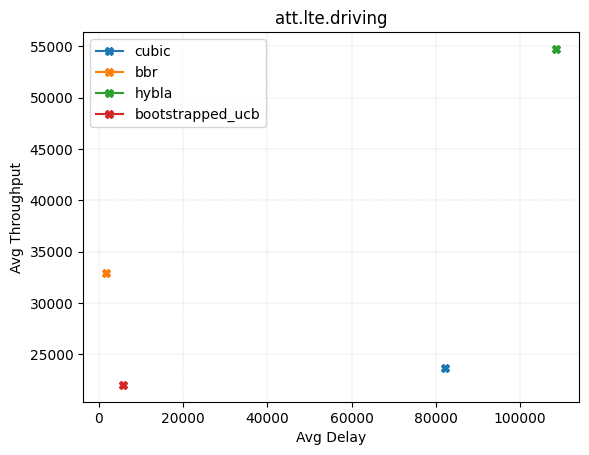

In [32]:
# for p, t in json_obj.keys():
save = False
line_styles = {'cubic':'-.', 'bbr':'--', 'hybla':':', 'bootstrapped_ucb':'-'}
for t in traces:
    for i, (p, tr) in enumerate(json_obj.keys()):
        if tr == t:
            # Get the feature array
            s_arr = build_features_per_step(p, t, json_obj)

            # Steps starting point on x-axis
            f_lenghts = [len(s_arr[k]) for k in sorted(s_arr.keys())[:-1]]
            step_starts = [sum(f_lenghts[:k]) for k in sorted(s_arr.keys())[:-1]]

            _, rtt_values, thr_values = get_features(s_arr)

            # plot the cwnd values for this protocol with a different line style
            line_style = line_styles[p]
            # plt = plot_feature(thr_values, protocol=p, linestyle=line_style)
            avg_delay = sum(rtt_values)/len(rtt_values)
            avg_thr = sum(thr_values)/len(thr_values)
            print(avg_delay, avg_thr)
            plt.plot(avg_delay, avg_thr, marker='X', label=p)


    plt.title(f"{t}")
    plt.xlabel('Avg Delay')
    plt.ylabel('Avg Throughput')
    plt.grid(linestyle='--', linewidth=0.2)
    plt.legend()
    if save:
        filename = f"{p}.{t}.thrs.png"
        plt.savefig(f"/home/lorenzo/Desktop/mimic-2/analysis/plots/thr_trends/{filename}")
    plt.show()